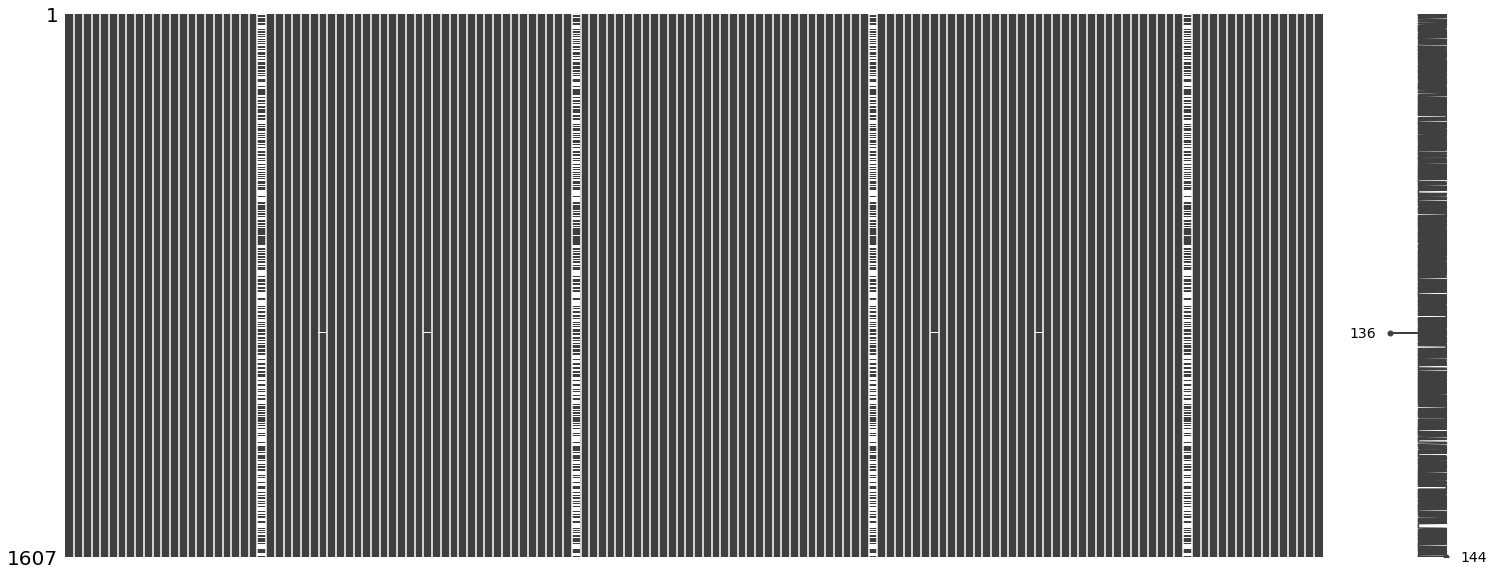

In [221]:
#import some packages
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#load csv dataset from github
df = pd.read_csv('https://raw.githubusercontent.com/yongyongkr/yongyong/main/train_data.csv')

#check missing values
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 1000)
df.isnull().sum()

#find missing values and drop it
msno.matrix(df)
df = df.drop(columns=['ST123CV','ST64CV','ST123TA','ST64TA'])
df = df.drop(index=943)
df.reset_index(drop=True, inplace=True)

#check whether missing values are completely dropped
df.isnull().sum()

#devide group
x = df.loc[:,'ST102CV':'ST99TA']
y = df.loc[:,'DX_bl']
z = df.loc[:,'ADAS11':'MMSE']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

1    50.684932
0    30.199253
2    19.115816
Name: DX_bl, dtype: float64


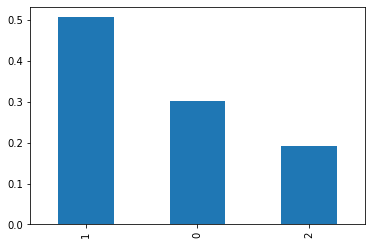

In [223]:
#split into train set and test set
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=55)
for train_index, test_index in split.split(x, y, z):
  x_train = x.loc[train_index]
  x_test = x.loc[test_index]
  y_train = y.loc[train_index]
  y_test = y.loc[test_index]
  z_train = z.loc[train_index]
  z_test = z.loc[test_index]

#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#check imbalanced data
df.DX_bl.value_counts(normalize=True).plot(kind='bar')
print(df.DX_bl.value_counts(normalize=True)*100)

from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio='auto', kind='regular')
x_train, y_train = sm.fit_sample(x_train, list(y_train))
x_test, y_test = sm.fit_sample(x_test, list(y_test))

 First, I loaded csv file and tried to analyze dataset.
 There were lots of missing values in 4 columns ('ST123CV','ST64CV','ST123TA','ST64TA') and some missing values in 1 row (index = 943).
 After checking whether there's no more missing values, I split dataset into train/test set. Then I scaled the values of 136 features.
 I also checked about the imbalanced data. Upper graph shows us there are imbalance between diagnosis groups. So I fixed it with SMOTE by oversampling the data.

In [226]:
#Task 1 starts
#1st model = RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
RFC_param_grid = {
    'n_estimators' : [200, 300],
    'max_depth' : [6, 8],
    'min_samples_leaf' : [2, 3],
    'min_samples_split' :[9, 10],
}

model1 = RandomForestClassifier(random_state=10)

#search for nice hyperparameters
RFC_grid = GridSearchCV(estimator=model1, 
                        param_grid = RFC_param_grid,
                        cv=10, 
                        n_jobs=-1, 
                        verbose=2
                        )
RFC_grid.fit(x_train, y_train)
print("best accuracy : {0:.4f}".format(RFC_grid.best_score_))
print("best parameter : ", RFC_grid.best_params_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.6min finished


best accuracy : 0.6749
best parameter :  {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 200}


In [233]:
#select hyperparameters
model1 = RandomForestClassifier(n_estimators=200, 
                                max_depth=8, 
                                min_samples_leaf=2, 
                                min_samples_split=9, 
                                max_features='sqrt')

from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(model1, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std() * 2))

model1.fit(x_train, y_train)
prediction1 = model1.predict(x_test)

from sklearn.metrics import confusion_matrix
predict1 = model1.predict(x_train)

print("confusion matrix of trainset")
print(confusion_matrix(y_train, predict2))
print("confusion matrix of testset")
print(confusion_matrix(y_test, prediction2))

Accuracy: 0.68 (+/- 0.10)
confusion matrix of trainset
[[551 155  27]
 [231 364 138]
 [ 21  93 619]]
confusion matrix of testset
[[56 17  8]
 [25 39 17]
 [ 0 27 54]]


In [235]:
#2nd model is LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
LR_param_grid = [
    {'penalty' : ['l1','l2','elasticnet','none'],
     'C': [0.01, 0.1, 1, 10],
     'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'multi_class' : ['ovr', 'multinomial']
    }
]
model2 = LogisticRegression(random_state=44)

#search for hyperparameters
LR_grid = GridSearchCV(estimator = model2, 
                       param_grid = LR_param_grid, 
                       cv = 10, 
                       verbose = True, 
                       n_jobs = -1)
LR_grid.fit(x_train,y_train)
print("best accuracy : {0:.4f}".format(LR_grid.best_score_))
print("best parameter : ", LR_grid.best_params_)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 131 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 500 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1084 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  4.7min finished


best accuracy : 0.6399
best parameter :  {'C': 1, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


In [237]:
#select hyperparameters
model2 = LogisticRegression(C=11, 
                            multi_class='ovr',
                            penalty= 'l1',
                            solver='liblinear', 
                            max_iter=1000)

from sklearn.model_selection import cross_val_score
scores2 = cross_val_score(model2, x_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

model2.fit(x_train, y_train)
prediction2 = model2.predict(x_test)

from sklearn.metrics import confusion_matrix
predict2 = model2.predict(x_train)

print("confusion matrix of trainset")
print(confusion_matrix(y_train, predict2))
print("confusion matrix of testset")
print(confusion_matrix(y_test, prediction2))

Accuracy: 0.64 (+/- 0.13)
confusion matrix of trainset
[[573 129  31]
 [238 326 169]
 [ 28  63 642]]
confusion matrix of testset
[[52 20  9]
 [26 34 21]
 [ 1 26 54]]


Epoch 1/40
62/62 [==============================] - 0s 3ms/step - loss: 1.1074 - accuracy: 0.4012 - val_loss: 1.1080 - val_accuracy: 0.5500
Epoch 2/40
62/62 [==============================] - 0s 1ms/step - loss: 0.9971 - accuracy: 0.4987 - val_loss: 0.9999 - val_accuracy: 0.6273
Epoch 3/40
62/62 [==============================] - 0s 1ms/step - loss: 0.9462 - accuracy: 0.5301 - val_loss: 0.9302 - val_accuracy: 0.6773
Epoch 4/40
62/62 [==============================] - 0s 1ms/step - loss: 0.9068 - accuracy: 0.5629 - val_loss: 0.8489 - val_accuracy: 0.7364
Epoch 5/40
62/62 [==============================] - 0s 1ms/step - loss: 0.8744 - accuracy: 0.5771 - val_loss: 0.7786 - val_accuracy: 0.7682
Epoch 6/40
62/62 [==============================] - 0s 1ms/step - loss: 0.8473 - accuracy: 0.5902 - val_loss: 0.7069 - val_accuracy: 0.7864
Epoch 7/40
62/62 [==============================] - 0s 1ms/step - loss: 0.8250 - accuracy: 0.6064 - val_loss: 0.6813 - val_accuracy: 0.7682
Epoch 8/40
62/62 [==

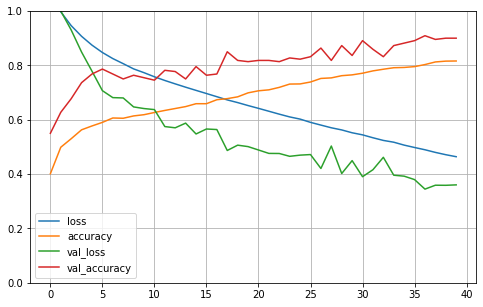

8/8 [==============================] - 0s 1ms/step - loss: 1.0119 - accuracy: 0.5185


[1.0119258165359497, 0.5185185074806213]

In [240]:
#3th model is NN, hidden layer is relu, output layer is softmax
import tensorflow as tf
from tensorflow import keras

model3 = keras.models.Sequential()
model3.add(keras.layers.Flatten(input_shape=[x_train.shape[1]]))
model3.add(keras.layers.Dense(50, activation="relu"))
model3.add(keras.layers.Dense(10, activation="relu"))
model3.add(keras.layers.Dense(3, activation="softmax"))

model3.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])



early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model3.fit(x_train, y_train, epochs=40,
                    validation_split=0.1)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

model3.evaluate(x_test, y_test)

  1st model = RandomForestClassifier
Accuracy: 0.68 (+/- 0.10)
confusion matrix of trainset
[[551 155  27]
 [231 364 138]
 [ 21  93 619]]
confusion matrix of testset
[[56 17  8]
 [25 39 17]
 [ 0 27 54]]

  2nd model = LogisticRegression
Accuracy: 0.64 (+/- 0.13)
confusion matrix of trainset
[[573 129  31]
 [238 326 169]
 [ 28  63 642]]
confusion matrix of testset
[[52 20  9]
 [26 34 21]
 [ 1 26 54]]
 
  3rd model = NN
loss: 1.0119 - accuracy: 0.5185

I used SearchGridCV to find appropriate hyperparameters for 1st and 2nd model.
I tried to use random search for neural network but my labtop keeps dying, so I put parameters by myself such as number of hidden layers or neurons.

My best model is RandomForestClassifier because it shows the highest accuracy among 3 models and confusion metrix of traingset and testset seems great.

In [241]:
#Task2
#devide group
x = df.loc[:,'ST102CV':'ST99TA']
y = df.loc[:,'DX_bl']
z = df.loc[:,'ADAS11':'MMSE']

#split into train set and test set
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=55)
for train_index, test_index in split.split(x, y, z):
  x_train = x.loc[train_index]
  x_test = x.loc[test_index]
  y_train = y.loc[train_index]
  y_test = y.loc[test_index]
  z_train = z.loc[train_index]
  z_test = z.loc[test_index]

#scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#4th model is LinearRegression
from sklearn.linear_model import LinearRegression
model4 = LinearRegression()
model4.fit(x_train, z_train)
predict4 = model4.predict(x_test)

from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(z_test, predict4)**0.5
print(RMSE)

5.114381636585601


In [242]:
#5th model is KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
model5 = KNeighborsRegressor()
model5.fit(x_train, z_train)
predict5 = model5.predict(x_test)

from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(z_test, predict5)**0.5
print(RMSE)

6.0309558190304555


In [245]:
#6th model is DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
model6 = DecisionTreeRegressor()
model6.fit(x_train, z_train)
predict6 = model6.predict(x_test)

from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(z_test, predict6)**0.5
print(RMSE)

6.8563521498908315


In [246]:
#7th model is LinearSVR (wrapped with MultiOutputRegressor)
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
model7 = LinearSVR(max_iter=10000)
wrapper = MultiOutputRegressor(model7)
wrapper.fit(x_train, z_train)
predict7 = wrapper.predict(x_test)

from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(z_test, predict7)**0.5
print(RMSE)

5.080343532090869


1st model = LinearRegression
2nd model = KNeighborsRegressor
3rd model = DecisionTreeRegressor
4th model = LinearSVR wrapped with MultiOutputRegressor

My best model is LinearSVR wrapped with MultiOutputRegressor. It shows us the least value of RMSE.

In [255]:
from sklearn.externals import joblib 
cls_weight = 'cls_model.pkl' 
joblib.dump(model1, "cls_model.pkl")

['cls_model.pkl']

In [260]:
reg_weight = 'reg_model.pkl' 
joblib.dump(model7, "reg_model.pkl")

['reg_model.pkl']